## Multiclass classification of histopathological images of lung and colon tissue

<center>
  <img src="../IMG/dataset-cover.jpeg" alt="Dataset cover" width="1000">
  <div style="font-size: smaller; font-style: italic;">
    Photo taken from Pixabay at Pexels
  </div>
</center>

### Introduction

Aim of this project is to distinguish **five classes**:
* Colon adenocarcinoma
* Colon benign tissue
* Lung adenocarcinoma
* Lung benign tissue
* Lung squamous cell carcinoma

The dataset utilized consists of lung and colon cancer **histopathological images**, containing 25,000 images. Each image is 768 x 768 pixels in *jpeg* file format. 
We will use **convolutional neural network** and Python with the `PyTorch` framework.


<center>
  <div style="display: flex; flex-direction: row; justify-content: center;">
   <div style="text-align: center; margin: 10px;">
      <img src="../DATA/lung_colon_image_set/colon_n/colonn1.jpeg" alt="colon n" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (1) colon benign tissue</div>
    </div>
    <div style="text-align: center; margin: 10px;">
      <img src="../DATA/lung_colon_image_set/colon_aca/colonca1.jpeg" alt="colon aca" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (2) colon adenocarcinoma</div>
    </div>
    <div style="text-align: center; margin: 10px;">
      <img src="../DATA/lung_colon_image_set/lung_n/lungn1.jpeg" alt="lung n" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (4) lung benign tissue</div>
    </div>
    <div style="text-align: center; margin: 10px;">
      <img src="../DATA/lung_colon_image_set/lung_aca/lungaca1.jpeg" alt="lung aca" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (3) lung adenocarcinoma</div>
    </div>
    <div style="text-align: center; margin: 10px;">
      <img src="../DATA/lung_colon_image_set/lung_scc/lungscc1.jpeg" alt="lung scc" width="200">
      <div style="font-size: smaller; font-style: italic;">
      (5) lung squamous cell carcinoma</div>
    </div>
  </div>
</center>

### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Data preprocessing

In [2]:
# Define transforms
transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder("../DATA/lung_colon_image_set", transform=transforms)

# Split the dataset into training and testing sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.1 * len(dataset))  # 10% for validation
test_size = len(dataset) - train_size - val_size  # 20% for testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

class_names = dataset.classes
print(class_names)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


### Convolutional Neural Network Model

In [3]:
# Define the neural network
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),  # Output: 32x64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),  # Output: 64x32x32
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),  # Output: 64x32x32
            
            nn.Flatten()
        )
        #self.classifier = nn.Linear(64*16*16, num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
            )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

### Create the network

In [4]:
# Instantiate the network
net = Net(num_classes=5)
print(net)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)


### Training loop

In [5]:
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation loop
    net.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print("Early stopping")
        break

print("Finished Training")


Epoch 1/10: 100%|██████████| 274/274 [07:19<00:00,  1.60s/batch]


Epoch [1/10], Loss: 0.5895, Accuracy: 74.87%
Validation Loss: 0.3074, Validation Accuracy: 87.56%


Epoch 2/10: 100%|██████████| 274/274 [06:47<00:00,  1.49s/batch]


Epoch [2/10], Loss: 0.3175, Accuracy: 86.98%
Validation Loss: 0.2750, Validation Accuracy: 88.40%


Epoch 3/10: 100%|██████████| 274/274 [06:46<00:00,  1.48s/batch]


Epoch [3/10], Loss: 0.2493, Accuracy: 89.92%
Validation Loss: 0.2085, Validation Accuracy: 91.68%


Epoch 4/10: 100%|██████████| 274/274 [06:48<00:00,  1.49s/batch]


Epoch [4/10], Loss: 0.2145, Accuracy: 91.55%
Validation Loss: 0.2088, Validation Accuracy: 91.48%


Epoch 5/10: 100%|██████████| 274/274 [06:48<00:00,  1.49s/batch]


Epoch [5/10], Loss: 0.1762, Accuracy: 93.07%
Validation Loss: 0.1644, Validation Accuracy: 93.24%


Epoch 6/10: 100%|██████████| 274/274 [06:53<00:00,  1.51s/batch]


Epoch [6/10], Loss: 0.1503, Accuracy: 94.14%
Validation Loss: 0.1641, Validation Accuracy: 93.12%


Epoch 7/10: 100%|██████████| 274/274 [06:48<00:00,  1.49s/batch]


Epoch [7/10], Loss: 0.1297, Accuracy: 95.03%
Validation Loss: 0.1088, Validation Accuracy: 96.36%


Epoch 8/10: 100%|██████████| 274/274 [06:49<00:00,  1.49s/batch]


Epoch [8/10], Loss: 0.1419, Accuracy: 94.50%
Validation Loss: 0.1633, Validation Accuracy: 93.64%


Epoch 9/10: 100%|██████████| 274/274 [06:54<00:00,  1.51s/batch]


Epoch [9/10], Loss: 0.0965, Accuracy: 96.35%
Validation Loss: 0.1237, Validation Accuracy: 94.60%


Epoch 10/10: 100%|██████████| 274/274 [06:51<00:00,  1.50s/batch]


Epoch [10/10], Loss: 0.0834, Accuracy: 96.91%
Validation Loss: 0.1665, Validation Accuracy: 93.80%
Finished Training


### Evaluation on the test set

In [6]:
# Evaluate on the test set and compute confusion matrix
net.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # using to confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 93.70%


### Training and Validation Losses and Accuracies

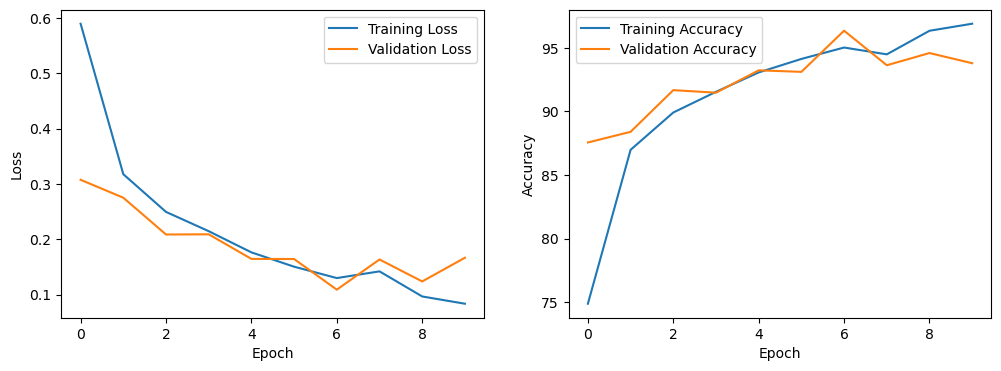

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Looking into

In [8]:
# Define transforms to match the ones used during training
image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Function to predict the class of an image
def predict_image(image_path, model, transform, class_names, true_class=None):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    model = model.to(device)

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Get model predictions
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    # Get the predicted class label
    predicted_class = class_names[predicted.item()]

    return predicted_class

# Path to the dataset directory
dataset_dir = "../DATA/lung_colon_image_set"

# Create the ImageFolder dataset
dataset = ImageFolder(
    dataset_dir,
    transform=image_transforms
)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the class names
class_names = dataset.classes

# Path to the image you want to classify
stop = 5000
counter = 0;
for i in range(1, stop + 1):
    image_path = "..\\DATA\\lung_colon_image_set\\colon_aca\\colonca" + str(i) + ".jpeg"

    # Get true class of the image
    true_class = os.path.basename(os.path.dirname(image_path))

    # Predict the class of the image
    predicted_class = predict_image(image_path, net, image_transforms, class_names, true_class=true_class)
    if true_class == predicted_class:
        print(image_path)
        break

# Optional: Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}\nTrue class: {true_class}")
plt.axis('off')
plt.show()


AttributeError: 'Compose' object has no attribute 'Compose'

### Confusion Matrix

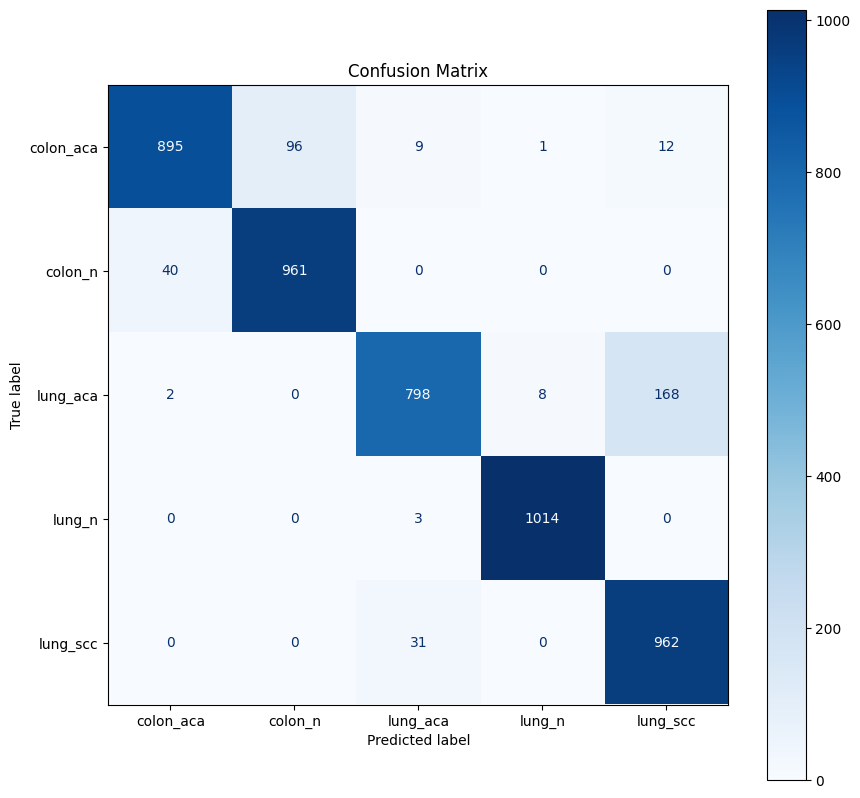

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

### Support Vector Machine 

In [ ]:
import torch
from torchvision import datasets, transforms
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # reduce the size of images
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder("../DATA/lung_colon_image_set", transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Transform data in batches
def batch_data_loader(dataset):
    data = []
    labels = []
    for img, label in dataset:
        img = img.view(-1).numpy()  # Flatten images into vector
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

# Transform training data
X_train, y_train = batch_data_loader(train_dataset)
# Transform test data
X_test, y_test = batch_data_loader(test_dataset)

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definition and training of the SVM model
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

# Prediction on the test set
y_pred = svm_model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')